In [1]:
from imutils import paths
from lxml import etree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
import os
import glob

In [2]:
#confirm the current working directory
os.getcwd()

'C:\\Users\\mattr\\Documents\\dog_breed'

In [3]:
os.chdir(r'C:\\Users\\mattr\\Documents\\dog_breed\\kaggle')

In [4]:
# grab the image paths and randomly shuffle them
imagePaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\kaggle\\train'))

In [5]:
# imagePaths

In [6]:
pathids = []

for i in range(len(imagePaths)):
    test = imagePaths[i]
    test = test.split('train\\',1)[1][:-4]
    pathids.append(test)

In [7]:
labels = pd.read_csv('labels.csv')

In [8]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
ids = labels.id

In [10]:
list(ids) == pathids

True

In [11]:
import tensorflow as tf
from keras.preprocessing.image import img_to_array, ImageDataGenerator

X = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (300, 300), interpolation = cv2.INTER_AREA)
    image = img_to_array(image)
    image = image/255
    X.append(image)

Using TensorFlow backend.


In [12]:
X = np.array(X)

In [13]:
onehot = pd.get_dummies(labels.breed)
y = np.array(onehot)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                   random_state = 123)

In [16]:
type(X_train)

numpy.ndarray

In [17]:
type(y_train)

numpy.ndarray

In [18]:
np.shape(X_train)

(9199, 300, 300, 3)

In [19]:
np.shape(y_train)

(9199, 120)

In [20]:
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [21]:
tf.keras.backend.clear_session()

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [22]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [23]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [24]:
# create the base pre-trained model
base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(300,300,3))

In [25]:
# add a global spatial average pooling layer
x = base.output
# let's add a fully-connected layer
x = Flatten()(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(120, activation='softmax')(x)

In [26]:
# this is the model we will train
inc_v3 = Model(inputs=base.input, outputs=predictions)

In [27]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base.layers:
    layer.trainable = False

In [28]:
sgd = SGD(lr=0.0002)
inc_v3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [29]:
# fits the model on batches with real-time data augmentation:
inc_v3.fit_generator(datagen.flow(X_train, y_train, batch_size=8),
                    steps_per_epoch=len(X_train) / 8, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/15
1150/1149 [==============================] - 206s 179ms/step - loss: 2.1994 - accuracy: 0.4764 - val_loss: 1.1064 - val_accuracy: 0.7116
Epoch 2/15
1150/1149 [==============================] - 156s 136ms/step - loss: 1.2761 - accuracy: 0.6520 - val_loss: 0.9449 - val_accuracy: 0.7634
Epoch 3/15
1150/1149 [==============================] - 152s 132ms/step - loss: 1.0507 - accuracy: 0.7078 - val_loss: 0.9513 - val_accuracy: 0.7683
Epoch 4/15
1150/1149 [==============================] - 152s 132ms/step - loss: 0.8887 - accuracy: 0.7454 - val_loss: 0.9381 - val_accuracy: 0.7595
Epoch 5/15
1150/1149 [==============================] - 152s 132ms/step - loss: 0.7463 - accuracy: 0.7826 - val_loss: 0.9524 - val_accuracy: 0.7742
Epoch 6/15
1150/1149 [==============================] - 152s 132ms/step - loss: 0.6547 - accuracy: 0.7998 - val_loss: 0.9981 - val_accuracy: 0.7703
Epoch 7/15
1150/1149 [==============================] - 152s 132ms/step - loss: 0.5665 - accuracy: 0.8276 - val_

In [30]:
# inc_v3.fit(X_train, y_train, batch_size=16, 
#           epochs=5, shuffle=True,
#          validation_data=(X_test, y_test))

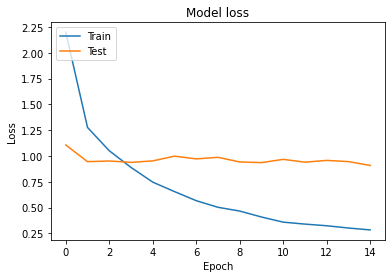

In [31]:
hist = inc_v3.history

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
testPaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\kaggle\\test'))

In [33]:
X_kag = []

# loop over the input images
for imagePath in testPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (300, 300), interpolation = cv2.INTER_AREA)
    image = img_to_array(image)
    image = image/255
    X_kag.append(image)

In [34]:
X_toscore = np.array(X_kag)

In [35]:
preds = inc_v3.predict(X_toscore)

In [36]:
np.savetxt("preds.csv", preds, delimiter=",")

In [37]:
# grab the image paths and randomly shuffle them
maniPaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\Mani'))

In [38]:
mani_pics = []

# loop over the input images
for mani in maniPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(mani)
    image = cv2.resize(image, (300, 300), interpolation = cv2.INTER_AREA)
#     image = tf.image.resize_with_crop_or_pad(image, 300, 300)
    image = img_to_array(image)
    image = image/255
    mani_pics.append(image)

In [39]:
mani_pics = np.array(mani_pics)

In [40]:
mani_preds = inc_v3.predict(mani_pics)

In [41]:
mani_preds

array([[1.3903321e-05, 1.8962120e-06, 1.8615403e-07, ..., 1.4659361e-06,
        1.1987031e-04, 4.4566659e-06],
       [2.9452985e-06, 4.2703894e-05, 1.0461661e-06, ..., 1.4780050e-04,
        1.1330902e-04, 6.3378736e-04],
       [4.1392752e-07, 5.5969335e-06, 8.1088996e-07, ..., 1.9738529e-06,
        2.9209318e-06, 2.8760201e-06],
       ...,
       [1.1985598e-05, 3.6556132e-06, 1.3449001e-05, ..., 2.7573944e-06,
        3.6970683e-04, 9.5255113e-05],
       [3.0470769e-06, 1.0740138e-06, 8.1655560e-07, ..., 3.0627743e-06,
        6.0282862e-05, 1.0228923e-05],
       [1.9562449e-06, 7.2084231e-07, 5.0343255e-07, ..., 1.3541211e-06,
        5.5080160e-05, 3.1879242e-06]], dtype=float32)

In [42]:
labels = list(pd.Series(labels.breed.unique()).sort_values())

In [43]:
finalpreds = pd.DataFrame(mani_preds, columns=labels)

In [44]:
finalpreds.idxmax(axis=1).value_counts()

eskimo_dog                     88
siberian_husky                 67
cardigan                       57
malamute                       44
border_collie                  35
pembroke                       25
norwegian_elkhound             13
basenji                         9
german_shepherd                 7
kelpie                          7
welsh_springer_spaniel          5
collie                          5
appenzeller                     4
schipperke                      4
entlebucher                     4
greater_swiss_mountain_dog      4
english_springer                4
bernese_mountain_dog            3
brittany_spaniel                3
toy_terrier                     2
golden_retriever                2
ibizan_hound                    1
lakeland_terrier                1
blenheim_spaniel                1
shetland_sheepdog               1
walker_hound                    1
english_setter                  1
miniature_pinscher              1
beagle                          1
bluetick      

In [45]:
# grab the image paths and randomly shuffle them
rouxPaths = list(paths.list_images(r'C:\\Users\\mattr\\Documents\\dog_breed\\Roux'))

In [46]:
roux_pics = []

# loop over the input images
for roux in rouxPaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(roux)
#     image = cv2.resize(image, (300, 300), interpolation = cv2.INTER_AREA)
    image = tf.image.resize_with_crop_or_pad(image, 300, 300)
    image = img_to_array(image)
    image = image/255
    roux_pics.append(image)
    
roux_pics = np.array(roux_pics)

In [47]:
roux_preds = inc_v3.predict(roux_pics)

In [48]:
rouxfinalpreds = pd.DataFrame(roux_preds, columns=labels)
rouxfinalpreds.idxmax(axis=1).value_counts()

bluetick                    2
brittany_spaniel            2
golden_retriever            1
australian_terrier          1
great_dane                  1
irish_terrier               1
irish_wolfhound             1
entlebucher                 1
chesapeake_bay_retriever    1
dtype: int64